# Module 1: BAG Workflow Demo
Welcome to the BAG tutorial! In this module, you will test run a simple demo of a common-source amplifier design to get an idea of generator-based design methodology.  This also serves to make sure you setup your workspace properly.

## BAG Workflow

<img src="bootcamp_pics/1_flow_demo/flow_demo_1.PNG" alt="Drawing" style="width: 600px"/>

The above flow diagram outlines how circuit design is typically done with BAG.  You will notice that it is largely similar to traditional manual design flow, with two major differences:

* Designer focus on designing schematic/layout/testbench generators, instead of specific circuit instances.
* Layout is usually done before schematic.

Discussions about the benefits of designing circuit generators instead of instances are outside of the scope of this tutorial, so I will assume you are already convinced.  So, why do we design layout generators before schematic generators?  There are several reasons:

* Since BAG can easily automates layout and post-extraction simulations, there is almost no need for schematic only simulations.
* One schematic could correspond to many different layouts (each with a different floorplan strategy), whereas one layout corresponds to exactly one schematic.
* It is impossible to determine schematic details such as dummy transistors before layout is done.


## BAG Schematic Example
<img src="bootcamp_pics/1_flow_demo/flow_demo_2.PNG" alt="Drawing" style="width: 500px"/>

The above figure shows the schematic template used for a common-source amplifier schematic generator, you can find this schematic in Virtuoso in library `demo_templates` and cell `amp_cs`.  Note that this is just like any other normal schematics, with the following differences:

* Transistors are from the `BAG_prim` library.  In this way this schematic can be ported across process by simply changing the `BAG_prim` library.
* Dummy transistors' ports are connected using wire stubs and net labels.  This allows BAG to easy reconnect those ports if necessary.

When BAG generates a new schematic, it will simply copy this schematic to a new library, then perform a set of modifications described by the schematic generator.  The modifications could include:

* Delete instances.
* Create new instances.
* Change the master of an instance.
* Reconnect instance terminals.
* Modify instance parameters.
* Add/Remove/Rename pins.


## Testbench Schematic Example
<img src="bootcamp_pics/1_flow_demo/flow_demo_3.PNG" alt="Drawing" style="width: 400px"/>
The above figure shows a schematic template for a DC operating point testbench generator, which can be found in library `bag_testbenches_ec` and cell `amp_tb_dc`.  It is just like the schematic template we seen before, but instead of a symbol view it has an ADEXL view.  To generate a new testbench, BAG will copy and modify both the schematic and the ADEXL view and returns a `Testbench` object that can be used to control simulations from Python.

## Testbench ADEXL Setup
<img src="bootcamp_pics/1_flow_demo/flow_demo_4.PNG" alt="Drawing" style="width: 500px"/>
The figure above shows the ADEXL view associated with a testbench template.  ADEXL is used to enable parametric/process corner sweeps.

## Running Demo Work Flow
```python
def run_flow(prj, specs, dsn_name, lay_cls, sch_cls=None, run_lvs=True, lvs_only=False):
    # generate layout, get schematic parameters from layout
    dsn_sch_params = gen_layout(prj, specs, dsn_name, lay_cls)
    # generate design/testbench schematics
    gen_schematics(prj, specs, dsn_name, dsn_sch_params, sch_cls=sch_cls, check_lvs=run_lvs, lvs_only=lvs_only)

    if lvs_only:
        # return if we're only running LVS
        print('LVS flow done')
        return

    # run simulation and import results
    simulate(prj, specs, dsn_name)

    # load simulation results from save file
    res_dict = load_sim_data(specs, dsn_name)
    # post-process simulation results
    plot_data(res_dict)

```
Now that you have an rough idea of how BAG generates new schematics and testbenches, let's try to run the common-source amplifier design flow.  To do so, simple select the code box below and press Ctrl+Enter to evaluate the Python code.  If everything works fine, you should see output messages in the dialog box below the code box, and it should end with DC/AC/Transient simulation plots.  Schematics, layouts, and testbenches should also be generated in the `DEMO_AMP_CS` library in Virtuoso, so you can take a look over there.

The Python script simply performs the following:

* Read a specification file to get schematic/layout/testbench/simulation parameters.
* Create a `BagProject` instance to perform various functions.
* Call the `run_flow()` method defined in Python module `xbase_demo.core` to execute the common source amplifier design flow.

The `xbase_demo.core` module is defined in the file `$BAG_WORK_DIR/BAG_XBase_demo/xbase_demo/core.py`.  You can take a look if you're interested, but the `run_flow()` method definition is reproduced above for your convenience.  You can see it simply calls other methods to generate layout/schematics, run simulations, and post-process simulation results.

creating BagProject
computing layout
ext_w0 = 1, ext_wend=6, tot_ntr=19
ext_w0 = 2, ext_wend=2, tot_ntr=18
final: ext_w0 = 2, ext_wend=2, tot_ntr=18
{'s': WireArray(TrackID(layer=3, track=7, num=9, pitch=2), 0.981, 1.136), 'd': WireArray(TrackID(layer=3, track=8, num=8, pitch=2), 1.168, 1.323), 'g': WireArray(TrackID(layer=3, track=8, num=8, pitch=2), 0.791, 0.946)}
WireArray(TrackID(layer=3, track=8, num=8, pitch=2), 0.791, 0.946)
5.5
creating layout
layout done
computing AMP_CS schematics
creating AMP_CS schematics
DEPRECATED WARNING: erase is no longer supported in implement_design() and has no effect
running lvs
Running tasks, Press Ctrl-C to cancel.
lvs passed
lvs log is /tools/projects/erichang/bag_gen/BAG2_cds_ff_mpt/pvs_run/lvs_run_dir/DEMO_AMP_CS/AMP_CS/lvsLog_20171127_090138086ysoof
computing AMP_CS_tb_dc schematics
creating AMP_CS_tb_dc schematics
DEPRECATED WARNING: erase is no longer supported in implement_design() and has no effect
computing AMP_CS_tb_ac_tran schematics
c

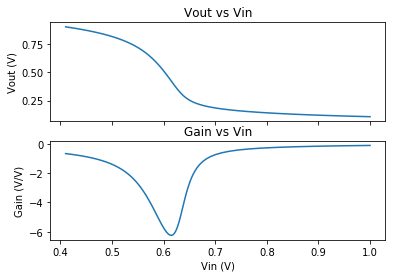

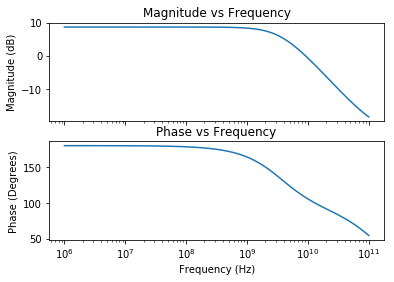

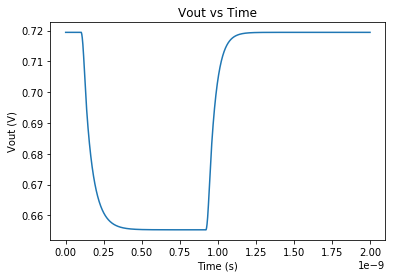

In [1]:
import os

# import bag package
import bag
from bag.io import read_yaml

# import BAG demo Python modules
import xbase_demo.core as demo_core
import xbase_demo.demo_layout.core as layout_core

# load circuit specifications from file
spec_fname = os.path.join(os.environ['BAG_WORK_DIR'], 'specs_demo/demo.yaml')
top_specs = read_yaml(spec_fname)

# obtain BagProject instance
local_dict = locals()
if 'bprj' in local_dict:
    print('using existing BagProject')
    bprj = local_dict['bprj']
else:
    print('creating BagProject')
    bprj = bag.BagProject()

demo_core.run_flow(bprj, top_specs, 'amp_cs', layout_core.AmpCS, run_lvs=True)

   ## Conclusion
   Congratulations!  You successfully walk through a BAG design flow.  In the following modules we will learn how to write simple layout and schematic generators in BAG.